# Животные 1

In [3]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.data import Subset
import torchvision.models as models

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

# root_dir = '/home/gladiator3000/.cache/kagglehub/datasets/sshikamaru/fruit-recognition/versions/2/train/train'
# test_path = '/home/gladiator3000/.cache/kagglehub/datasets/sshikamaru/fruit-recognition/versions/2/test'

Path to dataset files: /home/gladiator3000/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [5]:
trnsfrms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)

In [6]:
full_dataset = torchvision.datasets.ImageFolder(f'{path}/raw-img', transform=trnsfrms)

train_size = int(0.7 * len(full_dataset)) 
valid_size = len(full_dataset) - train_size  

train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])


In [8]:
# Предполагается, что train_dataset и valid_dataset созданы как Subset
# Например:
# train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# 1. Вывод списка классов
# Используем исходный датасет (full_dataset) для получения списка классов
print("Classes:", full_dataset.classes)

# 2. Вывод отображения class_to_idx
# Также используем исходный датасет
print("Class to Index Mapping:", full_dataset.class_to_idx)

# 3. Вывод размеров train_dataset и valid_dataset
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(valid_dataset))

Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Class to Index Mapping: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
Train Dataset Size: 18325
Validation Dataset Size: 7854


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=512)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=512)

In [ ]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)  # Pretrained=True

In [ ]:
test_batch = next(iter(train_loader))
test_b_s, test_b_l = test_batch
print(test_b_s.shape, test_b_l.shape)

torch.Size([512, 3, 224, 224]) torch.Size([512])


In [ ]:
tu.get_model_summary(model.to(DEVICE), test_b_s.to(DEVICE))

Layer                                                     Kernel               Output           Params              FLOPs
0_features.0.Conv2d_0                                    [3, 32, 3, 3]   [512, 32, 112, 112]         864    5,549,064,192
1_features.0.BatchNorm2d_1                                        [32]   [512, 32, 112, 112]          64      822,083,584
2_features.0.SiLU_2                                                  -   [512, 32, 112, 112]           0                0
3_features.1.0.block.0.Conv2d_0                          [1, 32, 3, 3]   [512, 32, 112, 112]         288    1,849,688,064
4_features.1.0.block.0.BatchNorm2d_1                              [32]   [512, 32, 112, 112]          64      822,083,584
5_features.1.0.block.0.SiLU_2                                        -   [512, 32, 112, 112]           0                0
6_features.1.0.block.1.AdaptiveAvgPool2d_avgpool                     -       [512, 32, 1, 1]           0      205,537,280
7_features.1.0.block.1.C

In [ ]:
model.to(DEVICE)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def fit_model(
        model: nn.Module,
        epochs: int,
        optimizer: torch.optim.Optimizer,
        criterion: torch.nn.modules.loss,
        history=None
    ):
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        batch_accs = []

        for samples, labels in train_loader:
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(samples)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        train_loss = np.mean(batch_losses)
        train_acc  = np.mean(batch_accs)
        history['train_losses'].append(train_loss)
        history['train_accs'].append(train_acc)

        model.eval()
        batch_losses = []
        batch_accs = []
        with torch.no_grad():
            for samples, labels in valid_loader:
                samples = samples.to(DEVICE)
                labels = labels.to(DEVICE)
                y_pred = model(samples)
                loss = criterion(y_pred, labels)
                batch_losses.append(loss.item())
                batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        valid_loss = np.mean(batch_losses)
        valid_acc  = np.mean(batch_accs)
        history['valid_losses'].append(valid_loss)
        history['valid_accs'].append(valid_acc)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}"
        )

    return history

In [ ]:


model.classifier[1] = nn.Linear(1280, 10)

In [ ]:
for param in model.parameters():
    param.requires_grad = False


In [ ]:
# model.fc.weight.requires_grad = True
# model.fc.bias.requires_grad = True

model.classifier[1].weight.requires_grad = True
model.classifier[1].bias.requires_grad = True

In [ ]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [ ]:
model.classifier[1]

Linear(in_features=1280, out_features=10, bias=True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
history = fit_model(model.to(DEVICE), optimizer=optimizer, criterion=criterion, epochs=10)

Epoch 1/10 | Train Loss: 1.2595, Train Acc: 0.7463 | Val Loss: 0.5820, Val Acc: 0.9120
Epoch 2/10 | Train Loss: 0.4827, Train Acc: 0.9128 | Val Loss: 0.3452, Val Acc: 0.9380
Epoch 3/10 | Train Loss: 0.3416, Train Acc: 0.9291 | Val Loss: 0.2756, Val Acc: 0.9422
Epoch 4/10 | Train Loss: 0.2853, Train Acc: 0.9365 | Val Loss: 0.2375, Val Acc: 0.9479
Epoch 5/10 | Train Loss: 0.2530, Train Acc: 0.9387 | Val Loss: 0.2152, Val Acc: 0.9482
Epoch 6/10 | Train Loss: 0.2331, Train Acc: 0.9422 | Val Loss: 0.2007, Val Acc: 0.9511
Epoch 7/10 | Train Loss: 0.2181, Train Acc: 0.9433 | Val Loss: 0.1867, Val Acc: 0.9534
Epoch 8/10 | Train Loss: 0.2038, Train Acc: 0.9481 | Val Loss: 0.1795, Val Acc: 0.9533
Epoch 9/10 | Train Loss: 0.1931, Train Acc: 0.9476 | Val Loss: 0.1742, Val Acc: 0.9536
Epoch 10/10 | Train Loss: 0.1844, Train Acc: 0.9515 | Val Loss: 0.1684, Val Acc: 0.9543


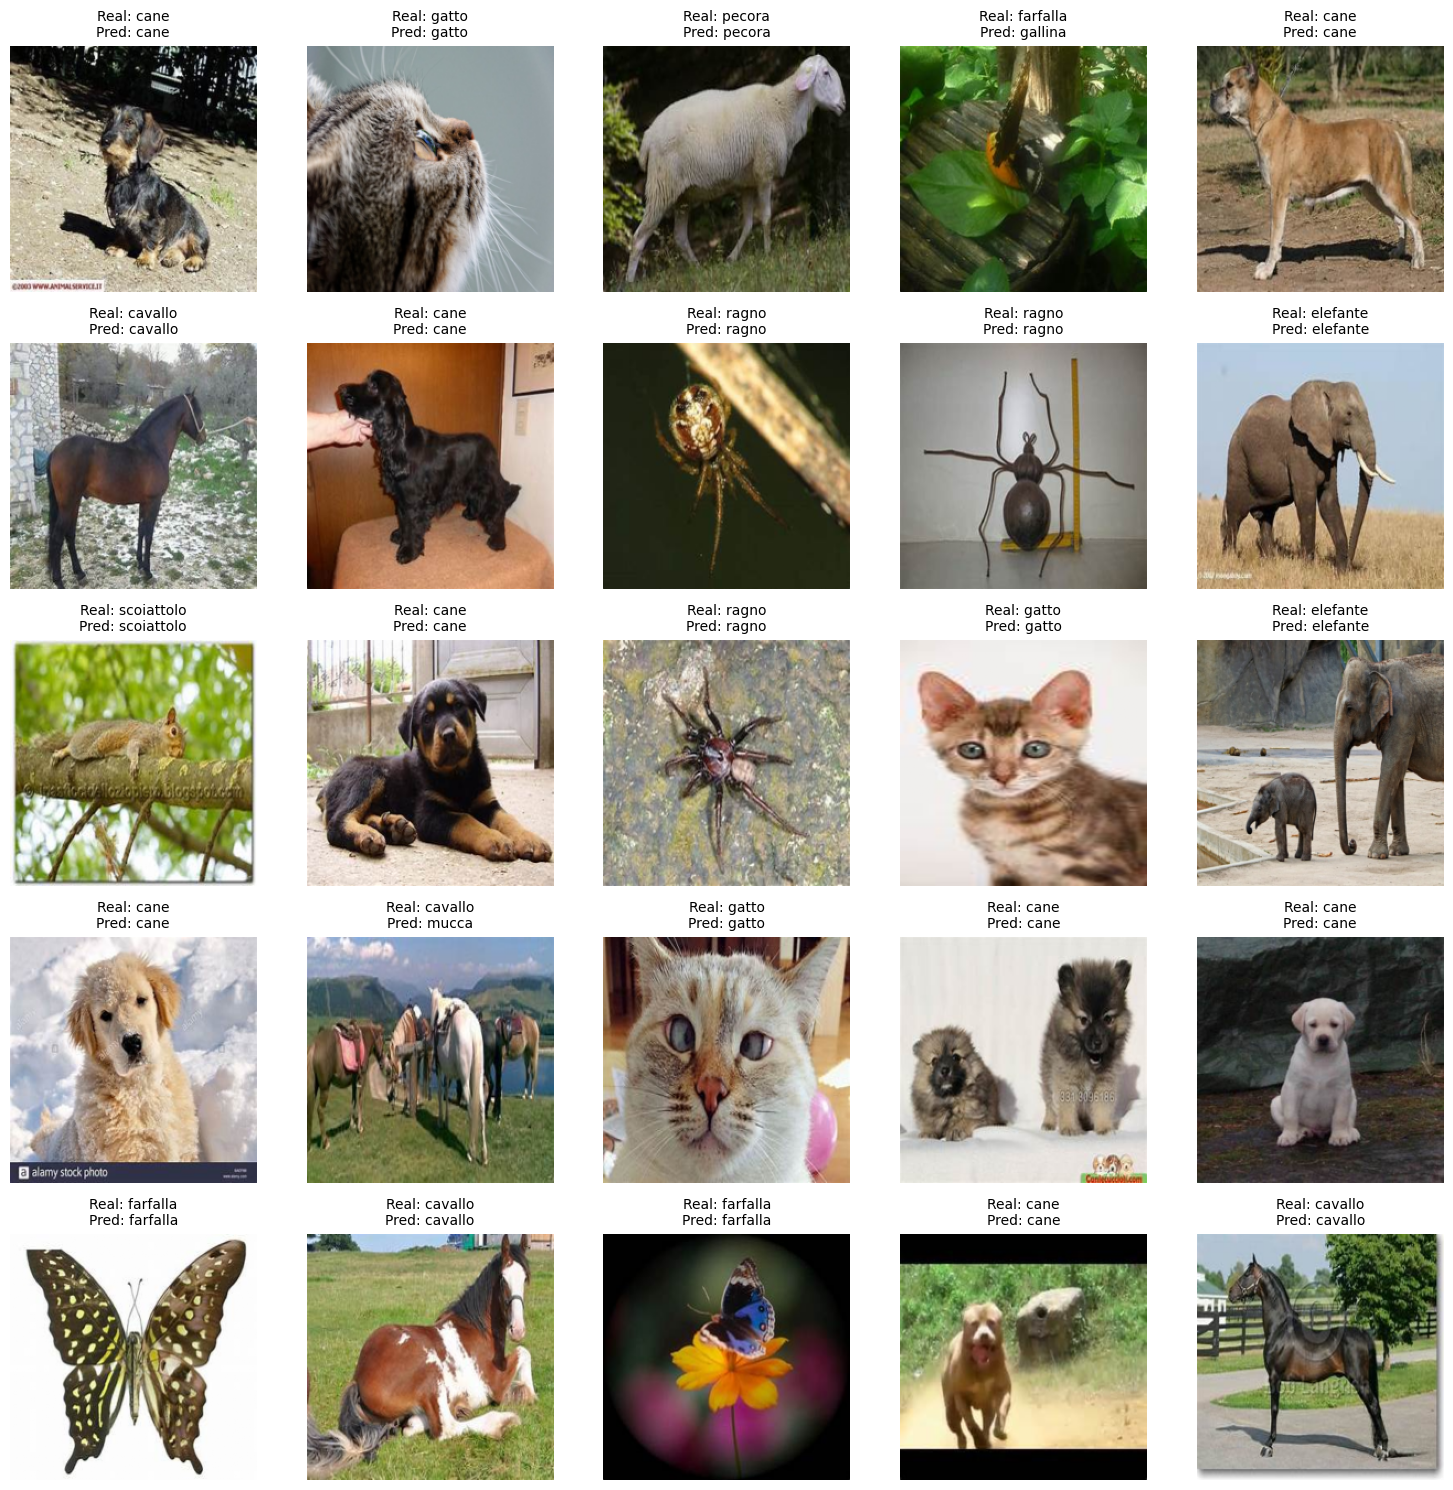

In [ ]:

classes = {v: k for k, v in full_dataset.class_to_idx.items()}  
grid_size = 5  
num_images = grid_size * grid_size
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    n = np.random.randint(len(valid_dataset))
    img = valid_dataset[n][0] 
    label = valid_dataset[n][1]  
    img_np = img.permute(1, 2, 0).numpy() 
    
    model.eval() 
    with torch.no_grad():
        pred = model(img.to(DEVICE).unsqueeze(0)) 
        predicted_class_idx = torch.argmax(pred, dim=1).item()  
    real_class = classes[label] 
    predicted_class = classes[predicted_class_idx]  

    ax.imshow(img_np)
    ax.set_title(f'Real: {real_class}\nPred: {predicted_class}', fontsize=10)
    ax.axis('off') 

plt.tight_layout()
plt.show()

In [ ]:
# model_path = "model_eurosat.pt"
# torch.save(model.state_dict(), model_path)
torch.save(model, "animal_new_model.pt")

: 